In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using Evolutionary
using Random
using BlackBoxOptim

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


In [2]:
include("unicycle_env.jl")
include("controller.jl")
include("problem.jl")

costs (generic function with 1 method)

In [3]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obs_radius = 0.5

0.5

In [4]:
mutable struct CollisionIndex
    margin
    gamma
    phi_power
    dot_phi_coe
end
mutable struct FollowingIndex
    d_min
    d_max
    margin
    gamma
    phi_power
    dot_phi_coe
end

In [5]:
function phi_safe_set(index, x, obstacles, dt)
    safe_set = nothing
    for obs in obstacles
        p = phi(index, x, obs)
        p_phi_p_x, p_phi_p_o = grad_phi(index, x, obs)
#         gamma = 1e-3
        dot_o = [obs.vel; [0.,0.]]
#         @show p_phi_p_o'dot_o
        d = p < 0 ? (-p-p_phi_p_o'dot_o)/dt : (-index.gamma-p_phi_p_o'dot_o)/dt
        safe_set = isnothing(safe_set) ? HalfSpace(p_phi_p_x, d) : intersection(HalfSpace(p_phi_p_x, d), safe_set)
    end
    return safe_set
end

function phi(index::CollisionIndex, x, obs)
    o = [obs.center; [0,0]]
    d = sqrt((x[1]-o[1])^2 + (x[2]-o[2])^2)
    dM = [x[1]-o[1], x[2]-o[2], x[3]*cos(x[4])-o[3], x[3]*sin(x[4])-o[4]]
    dim = 2
    dp = dM[[1,dim]]
    dv = dM[[dim+1,dim*2]]
    dot_d = dp'dv / d
    return (index.margin + obs.radius)^index.phi_power - d^index.phi_power - index.dot_phi_coe*dot_d
end

function grad_phi(index::CollisionIndex, x, obs)
    o = [obs.center; [0,0]]
    d = (x[1]-o[1])^2 + (x[2]-o[2])^2
    grad_d = [2*(x[1]-o[1]), 2*(x[2]-o[2]), 0, 0]

    d = sqrt((x[1]-o[1])^2 + (x[2]-o[2])^2)
    dM = [x[1]-o[1], x[2]-o[2], x[3]*cos(x[4])-o[3], x[3]*sin(x[4])-o[4]]
    dim = 2
    dp = dM[[1,dim]]
    dv = dM[[dim+1,dim*2]]
    dot_d = dp'dv / d
    p_dot_d_p_dp = dv / d - (dp'dv) * dp / (d^3)
    p_dot_d_p_dv = dp / d
    p_dp_p_M = hcat(I(dim), zeros(dim,dim))
    p_dv_p_M = hcat(zeros(dim,dim), I(dim))
    p_dot_d_p_M = p_dp_p_M'p_dot_d_p_dp + p_dv_p_M'p_dot_d_p_dv
    p_M_p_X = [
        1 0 0 0
        0 1 0 0
        0 0 cos(x[4]) -x[3]*sin(x[4])
        0 0 sin(x[4]) x[3]*cos(x[4])
    ]
    p_dot_d_p_X = p_M_p_X'p_dot_d_p_M
    grad_dot_d = vec(p_dot_d_p_X)
    return -index.phi_power*d^(index.phi_power-1)*grad_d - index.dot_phi_coe*grad_dot_d, zeros(4)
end

grad_phi (generic function with 1 method)

In [6]:
mutable struct Obstacle
    center
    vel
    radius
end

function phi(index::FollowingIndex, x, target)
    o = [target.center; target.vel]
    d = sqrt((x[1]-o[1])^2 + (x[2]-o[2])^2)
    dM = [x[1]-o[1], x[2]-o[2], x[3]*cos(x[4])-o[3], x[3]*sin(x[4])-o[4]]
    dim = 2
    dp = dM[[1,dim]]
    dv = dM[[dim+1,dim*2]]
    dot_d = dp'dv / d
    phi_0 = (d-index.d_min)^index.phi_power*(d-index.d_max)^index.phi_power 
    dot_phi_0 = index.dot_phi_coe*(2*d*dot_d + dot_d*(index.d_min+index.d_max))
    return (d-(index.d_min+index.margin))^index.phi_power*(d-(index.d_max-index.margin))^index.phi_power + index.dot_phi_coe*(2*d*dot_d - dot_d*(index.d_min+index.d_max))
end

function grad_phi(index::FollowingIndex, x, target)
    o = [target.center; target.vel]
    d = (x[1]-o[1])^2 + (x[2]-o[2])^2
    grad_d = [2*(x[1]-o[1]), 2*(x[2]-o[2]), 0, 0]

    d = sqrt((x[1]-o[1])^2 + (x[2]-o[2])^2)
    dM = [x[1]-o[1], x[2]-o[2], x[3]*cos(x[4])-o[3], x[3]*sin(x[4])-o[4]]
    dim = 2
    dp = dM[[1,dim]]
    dv = dM[[dim+1,dim*2]]
    
    p_Mr_p_Xr = [
        1 0 0 0
        0 1 0 0
        0 0 cos(x[4]) -x[3]*sin(x[4])
        0 0 sin(x[4]) x[3]*cos(x[4])
    ]
    p_Mh_p_Xh = I(4)
    #dot_d is the component of velocity lies in the dp direction
    dot_d = dp'dv / d

    p_dot_d_p_dp = dv / d - (dp'dv) * dp / (d^3)
    p_dot_d_p_dv = dp / d

    p_dp_p_Mr = hcat(I(dim), zeros(dim,dim))
    p_dp_p_Mh = -p_dp_p_Mr

    p_dv_p_Mr = hcat(zeros(dim,dim), I(dim))
    p_dv_p_Mh = -p_dv_p_Mr

    p_dot_d_p_Mr = p_dp_p_Mr'p_dot_d_p_dp + p_dv_p_Mr'p_dot_d_p_dv
    p_dot_d_p_Mh = p_dp_p_Mh'p_dot_d_p_dp + p_dv_p_Mh'p_dot_d_p_dv

    p_dot_d_p_Xr = p_Mr_p_Xr'p_dot_d_p_Mr
    p_dot_d_p_Xh = p_Mh_p_Xh'p_dot_d_p_Mh

    d = (d == 0) ? 1e-3 : d
    dot_d = (dot_d == 0) ? 1e-3 : dot_d

    p_d_p_Mr = vcat(dp / d, zeros(dim))
    p_d_p_Mh = vcat(-dp / d, zeros(dim))

    p_d_p_Xr = p_Mr_p_Xr'p_d_p_Mr
    p_d_p_Xh = p_Mh_p_Xh'p_d_p_Mh
    
    p_phi_p_x = index.phi_power*p_d_p_Xr*(d-(index.d_min+index.margin))^(index.phi_power-1)*(d-(index.d_max-index.margin))^(index.phi_power-1)*(d-index.d_max+d-index.d_min) +
                index.dot_phi_coe*(2*p_d_p_Xr*dot_d + 2*d*p_dot_d_p_Mr - p_dot_d_p_Xr*(index.d_min+index.d_max))

    p_phi_p_o = index.phi_power*p_d_p_Mh*(d-(index.d_min+index.margin))^(index.phi_power-1)*(d-(index.d_max-index.margin))^(index.phi_power-1)*(d-index.d_max+d-index.d_min) +
                index.dot_phi_coe*(2*p_d_p_Mh*dot_d + 2*d*p_dot_d_p_Mh - p_dot_d_p_Xh*(index.d_min+index.d_max))

    return p_phi_p_x, p_phi_p_o
end

grad_phi (generic function with 2 methods)

In [7]:
function generate_moving_target(;fps=10, tf=2, v=nothing, v_lim=0.5)
    T = tf*fps
    v = isnothing(v) ? [rand(), rand()]*v_lim*2 .- v_lim : v
    p = [0, 1.5]
    return [Obstacle(p+v*(i/fps), v, obs_radius) for i in 0:T-1]
end

function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

function tracking(rp::RP, ctrl; fps=10, tf=2, obstacles=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    col_cnt = 0
    infeas=false
    for i in 1:T-1
        Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=obstacles, safety_index=safety_index)
        u, safe_set = timed_result.value
        if isnothing(u)
            u = i == 1 ? [0.,0.] : U[i-1]
            infeas=true
            return X[1:i], U[1:i-1], safe_sets, Xrefs, true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(x, obstacle)
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
        if norm(x[1:2] - rp.xg[1:2]) < 0.1
            return X[1:i+1], U[1:i], safe_sets[1:i], Xrefs[1:i], infeas
        end
    end
#     @show length(Xrefs)
    push!(Xrefs, Xrefs[end])
#     @show length(Xrefs)
    return X, U, safe_sets, Xrefs, infeas
end

function following(rp::RP, ctrl; fps=10, tf=2, targets=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    infeas=false
    for i in 1:T-1
        xg = [targets[i].center..., norm(targets[i].vel), 0]
        @show
        Xref = get_Xref(x, xg, fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=[targets[i]], safety_index=safety_index)
        u, safe_set = timed_result.value
        if isnothing(u)
            u = i == 1 ? [0.,0.] : U[i-1]
            infeas=true
#             return X[1:i], U[1:i-1], safe_sets, Xrefs, true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(safety_index, x, targets[i])
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

following (generic function with 1 method)

In [8]:
include("unicycle_env.jl")

generate_random_traj (generic function with 1 method)

In [161]:
Random.seed!(1)
n = 1
obstacles0 = [Obstacle([rand()*1-0.5, 3], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)
# shoot_ctrl = ShootingController(1000)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)

ci = CollisionIndex(0.0, 1e-3, 1, 0)

Xexec0, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=20, obstacles=obstacles0, safety_index=ci, verbose=false);

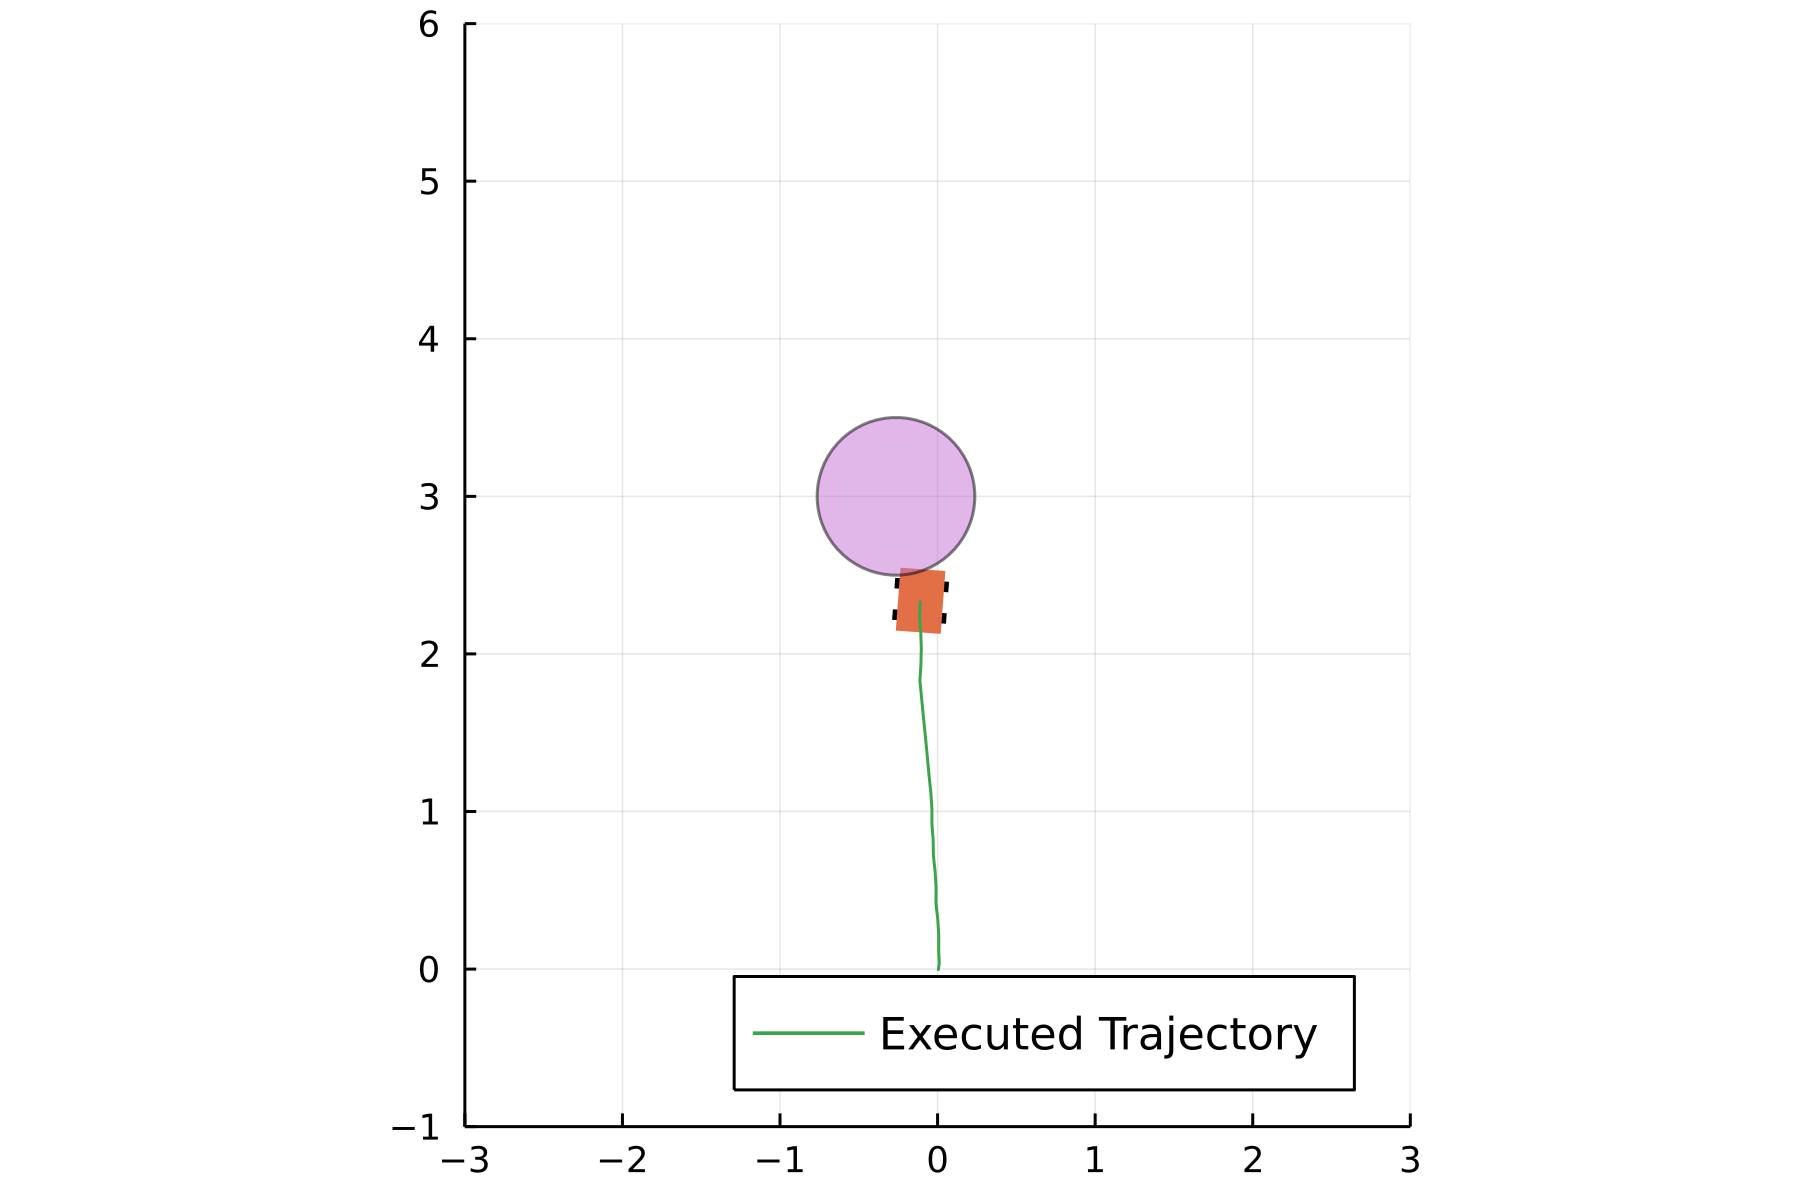

true

In [162]:
visualize(Xexec0, obstacles=obstacles0, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec0)-1, "../results/collision_0.png"))

In [9]:
Random.seed!(1)
n = 1
obstacles1 = [Obstacle([rand()*1-0.5, 3], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)
err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.728854, 0.00915763, 0.277308, 1.05736)
Xexec1, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=20, obstacles=obstacles1, safety_index=ci, verbose=false);

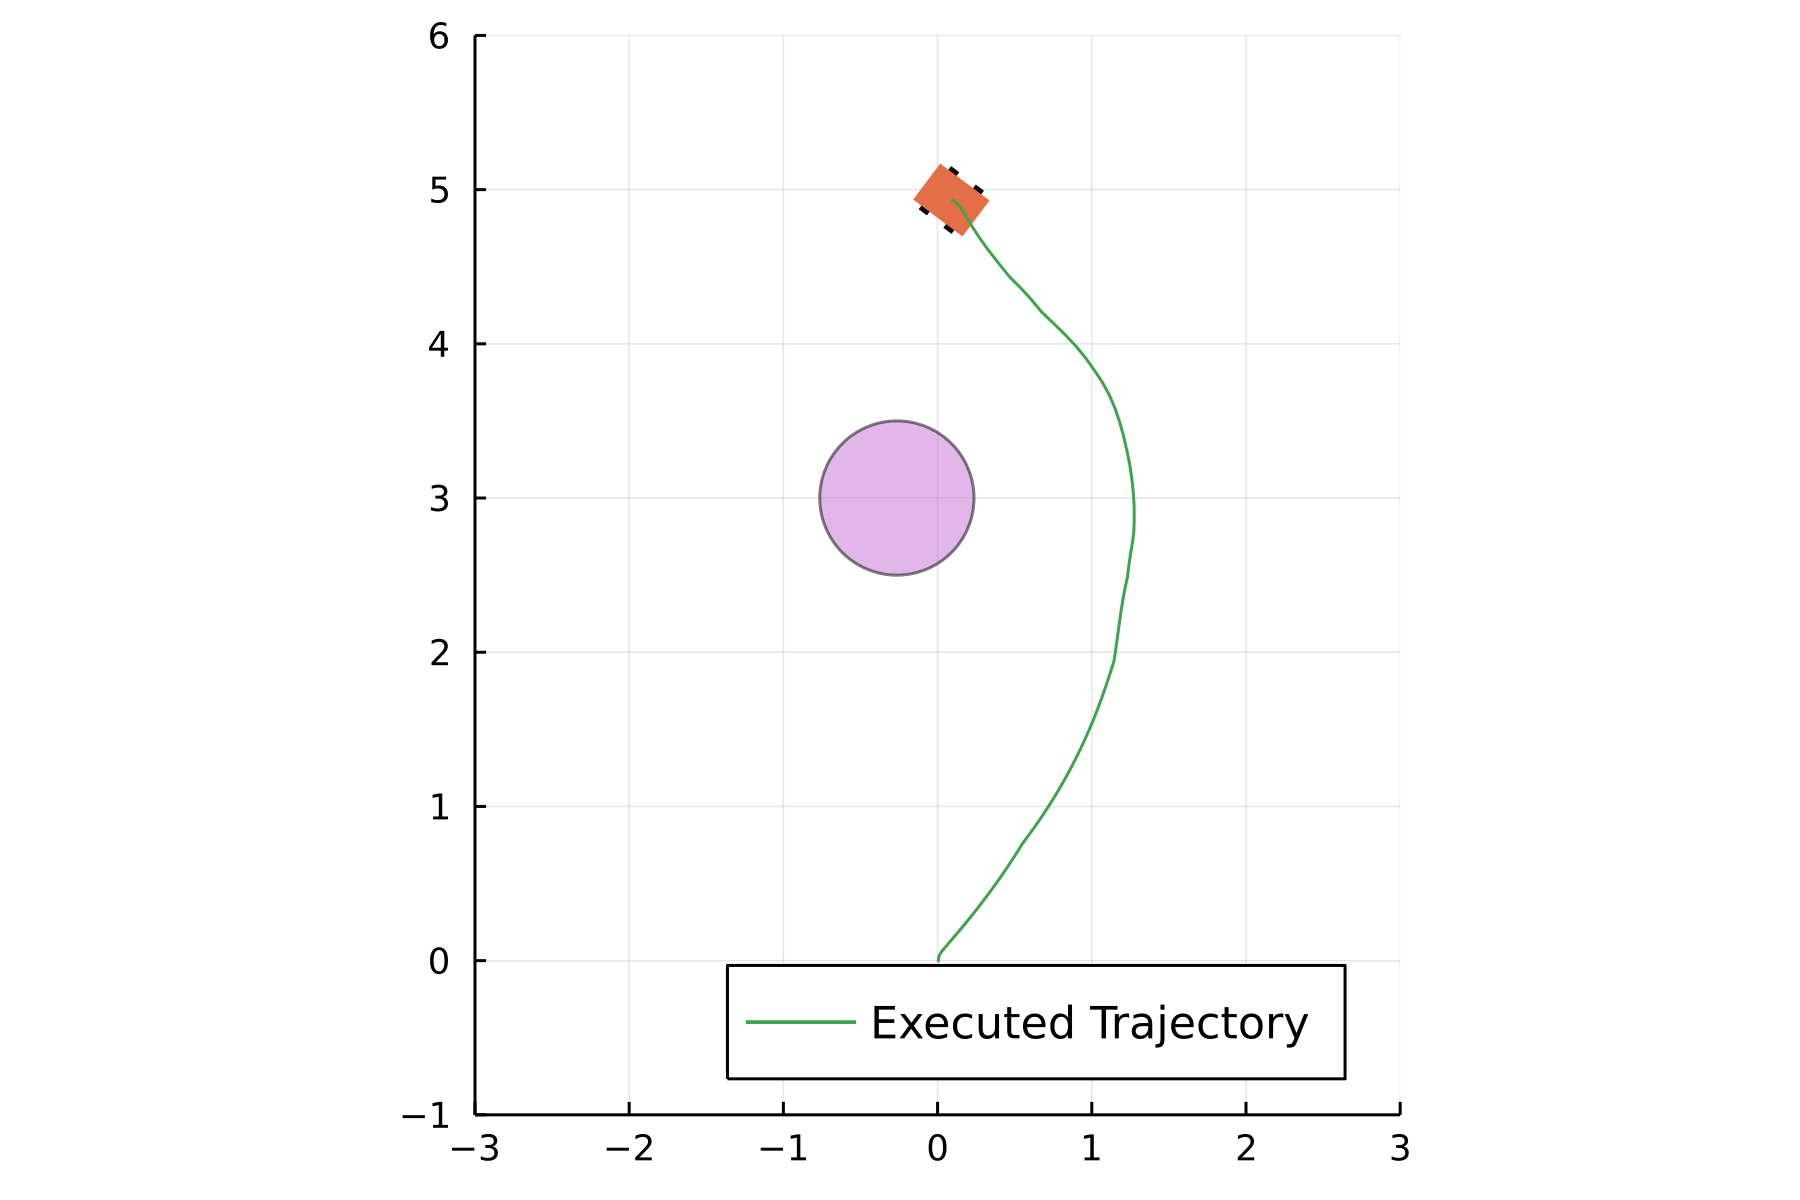

true

In [50]:
# visualize(Xexec1, obstacles=obstacles1, xlims=[-3,3], ylims=[-1,6], fps=100)
visualize(Xexec1, obstacles=obstacles1, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec1)-1, "../results/phi_collision_1.png"))

In [48]:
Random.seed!(7)
n = 2
obstacles2 = [Obstacle([rand()*1-1, rand()*1.5+1.5], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.728854, 0.00915763, 0.277308, 1.05736)
Xexec2, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=100, obstacles=obstacles2, safety_index=ci, verbose=false);

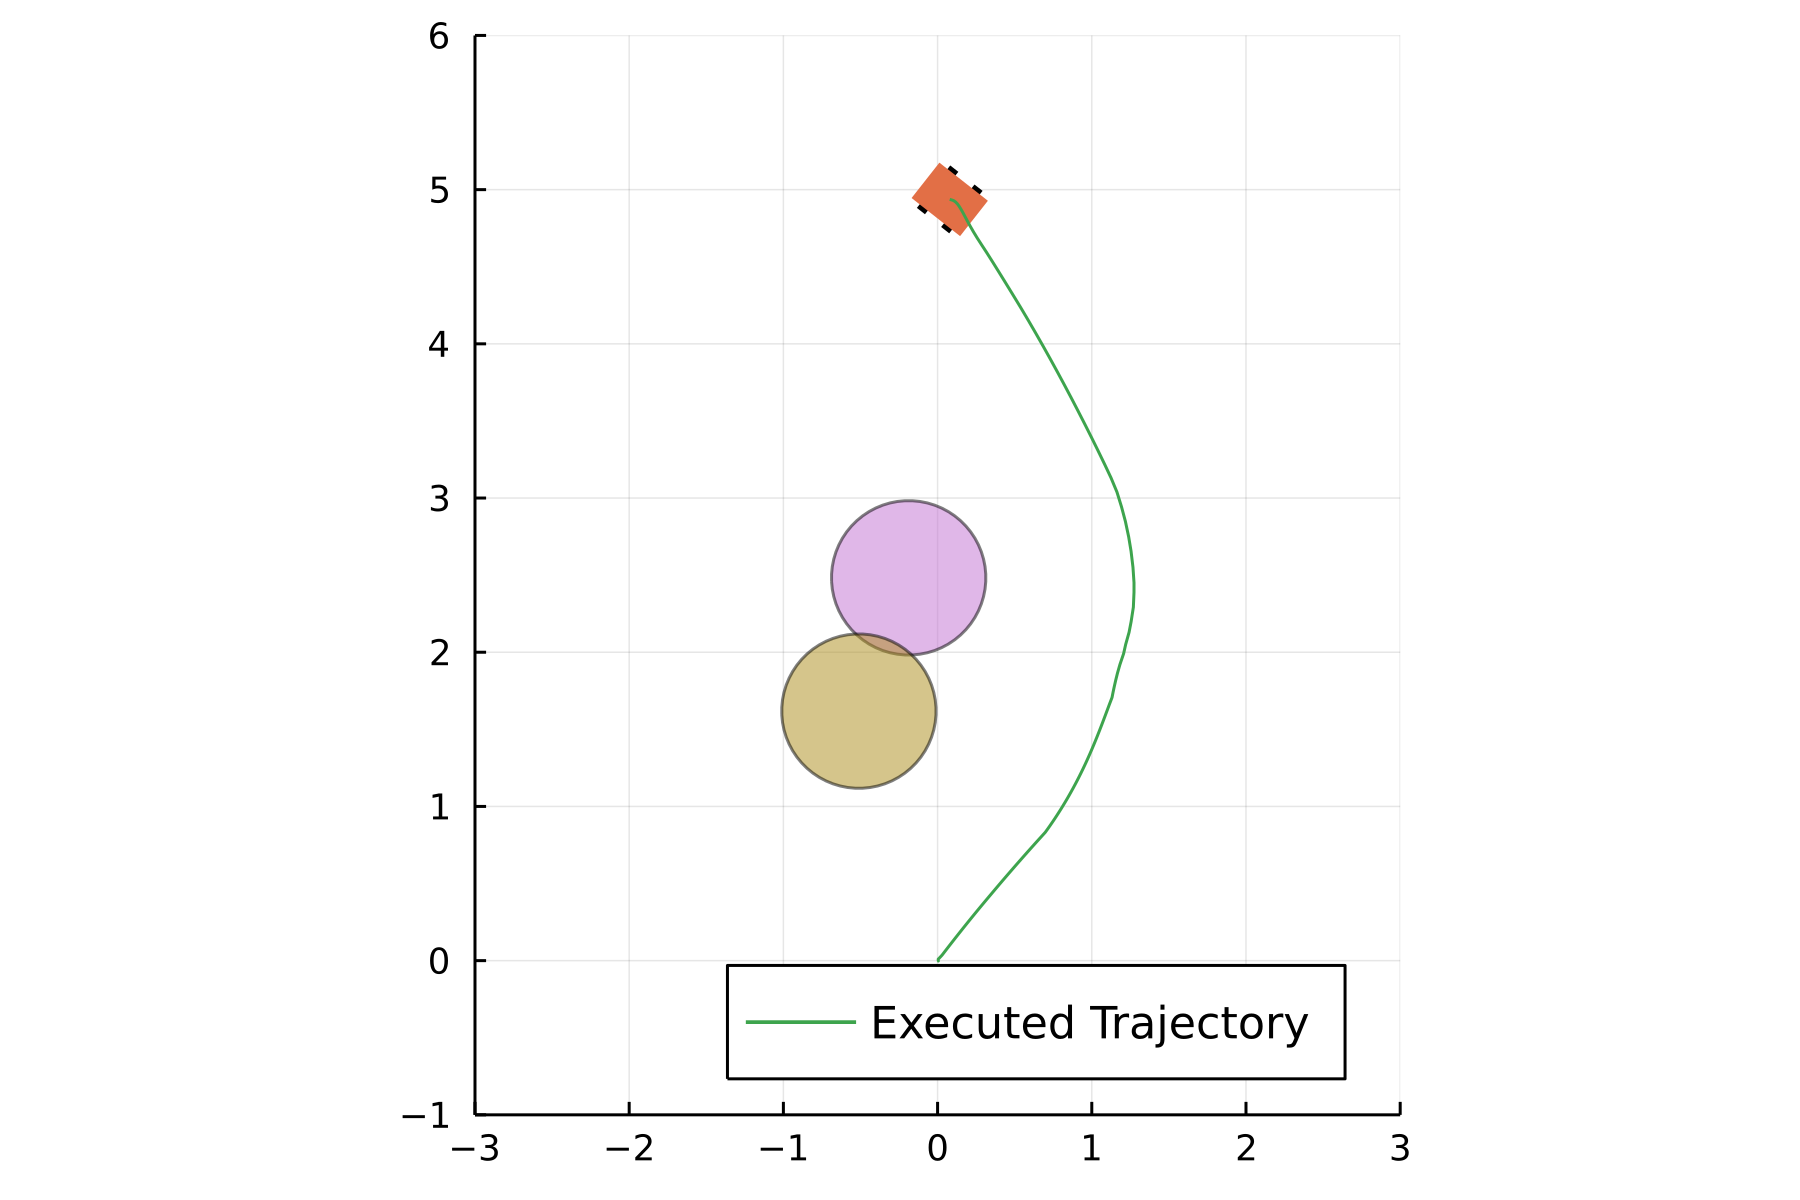

true

In [51]:
# visualize(Xexec2, obstacles=obstacles2, xlims=[-3,3], ylims=[-1,6], fps=100)
visualize(Xexec2, obstacles=obstacles2, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec2)-1, "../results/phi_collision_2.png"))

In [97]:
Random.seed!(12)
n = 3
obstacles3 = [Obstacle([rand()*1-1, rand()+i*0.5+0.5], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.728854, 0.00915763, 0.277308, 1.05736)
Xexec3, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=100, obstacles=obstacles3, safety_index=ci, verbose=false);

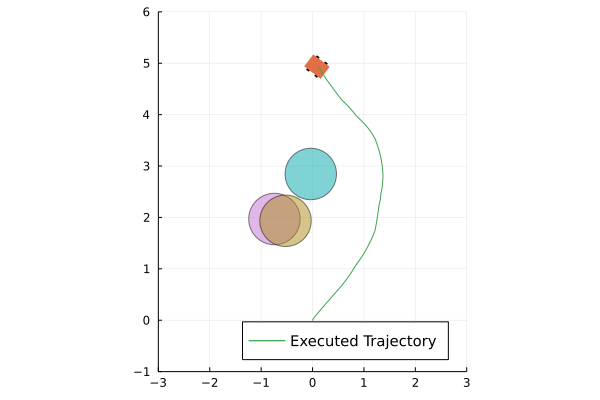

true

In [98]:
visualize(Xexec3, obstacles=obstacles3, xlims=[-3,3], ylims=[-1,6], fps=1000)
# visualize(Xexec3, obstacles=obstacles3, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec3)-1, "../results/phi_collision_3.png"))

In [158]:
Random.seed!(1)
n = 1
obstacles1 = [Obstacle([rand()*1-0.5, 3], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)
err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.1, 1e-3, 2, 1)

Xexec1, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=20, obstacles=obstacles1, safety_index=ci, verbose=false);

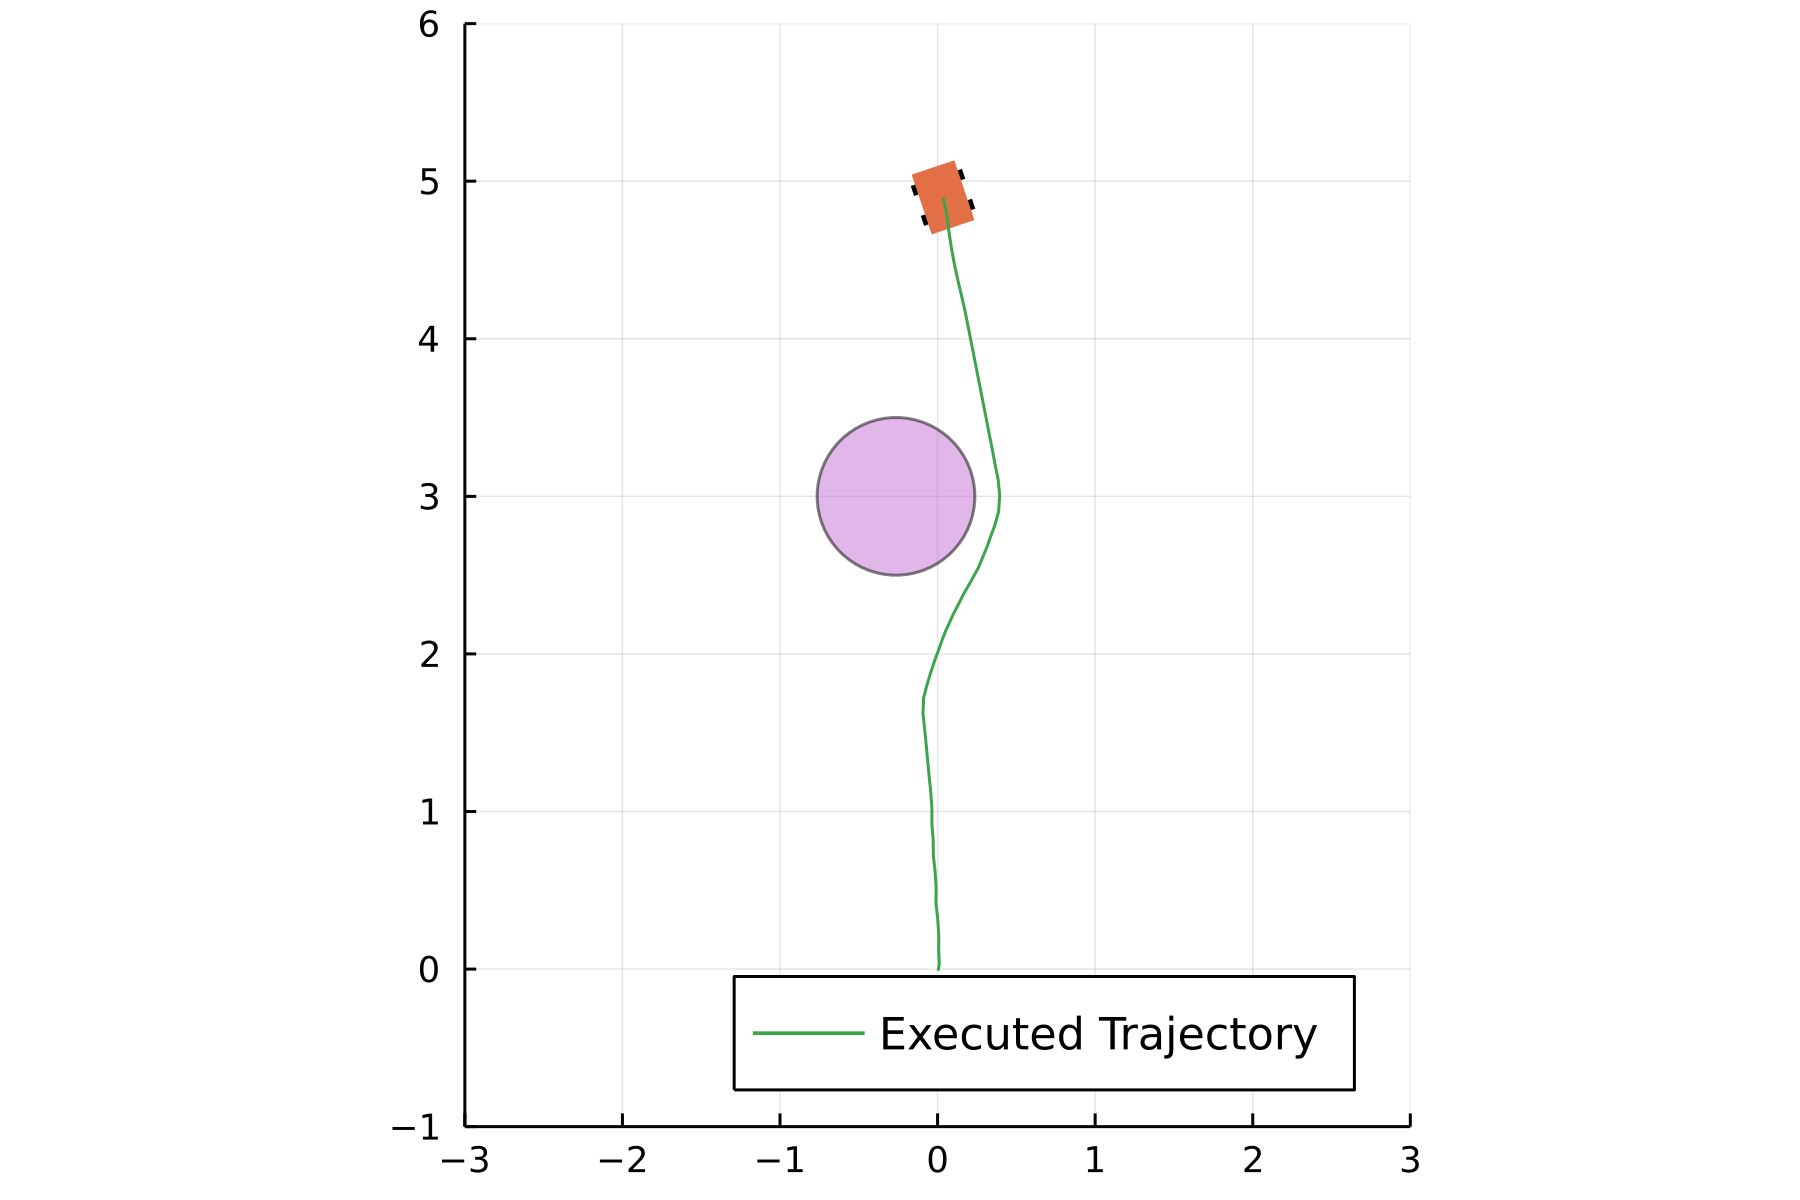

true

In [159]:
visualize(Xexec1, obstacles=obstacles1, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec1)-1, "../results/collision_1.png"))

In [88]:
Random.seed!(5)
n = 2
obstacles2 = [Obstacle([rand()*1.6-0.8, rand()*1+(i-1)*2+1], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.1, 1e-3, 2, 1)

Xexec2, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=20, obstacles=obstacles2, safety_index=ci, verbose=false);

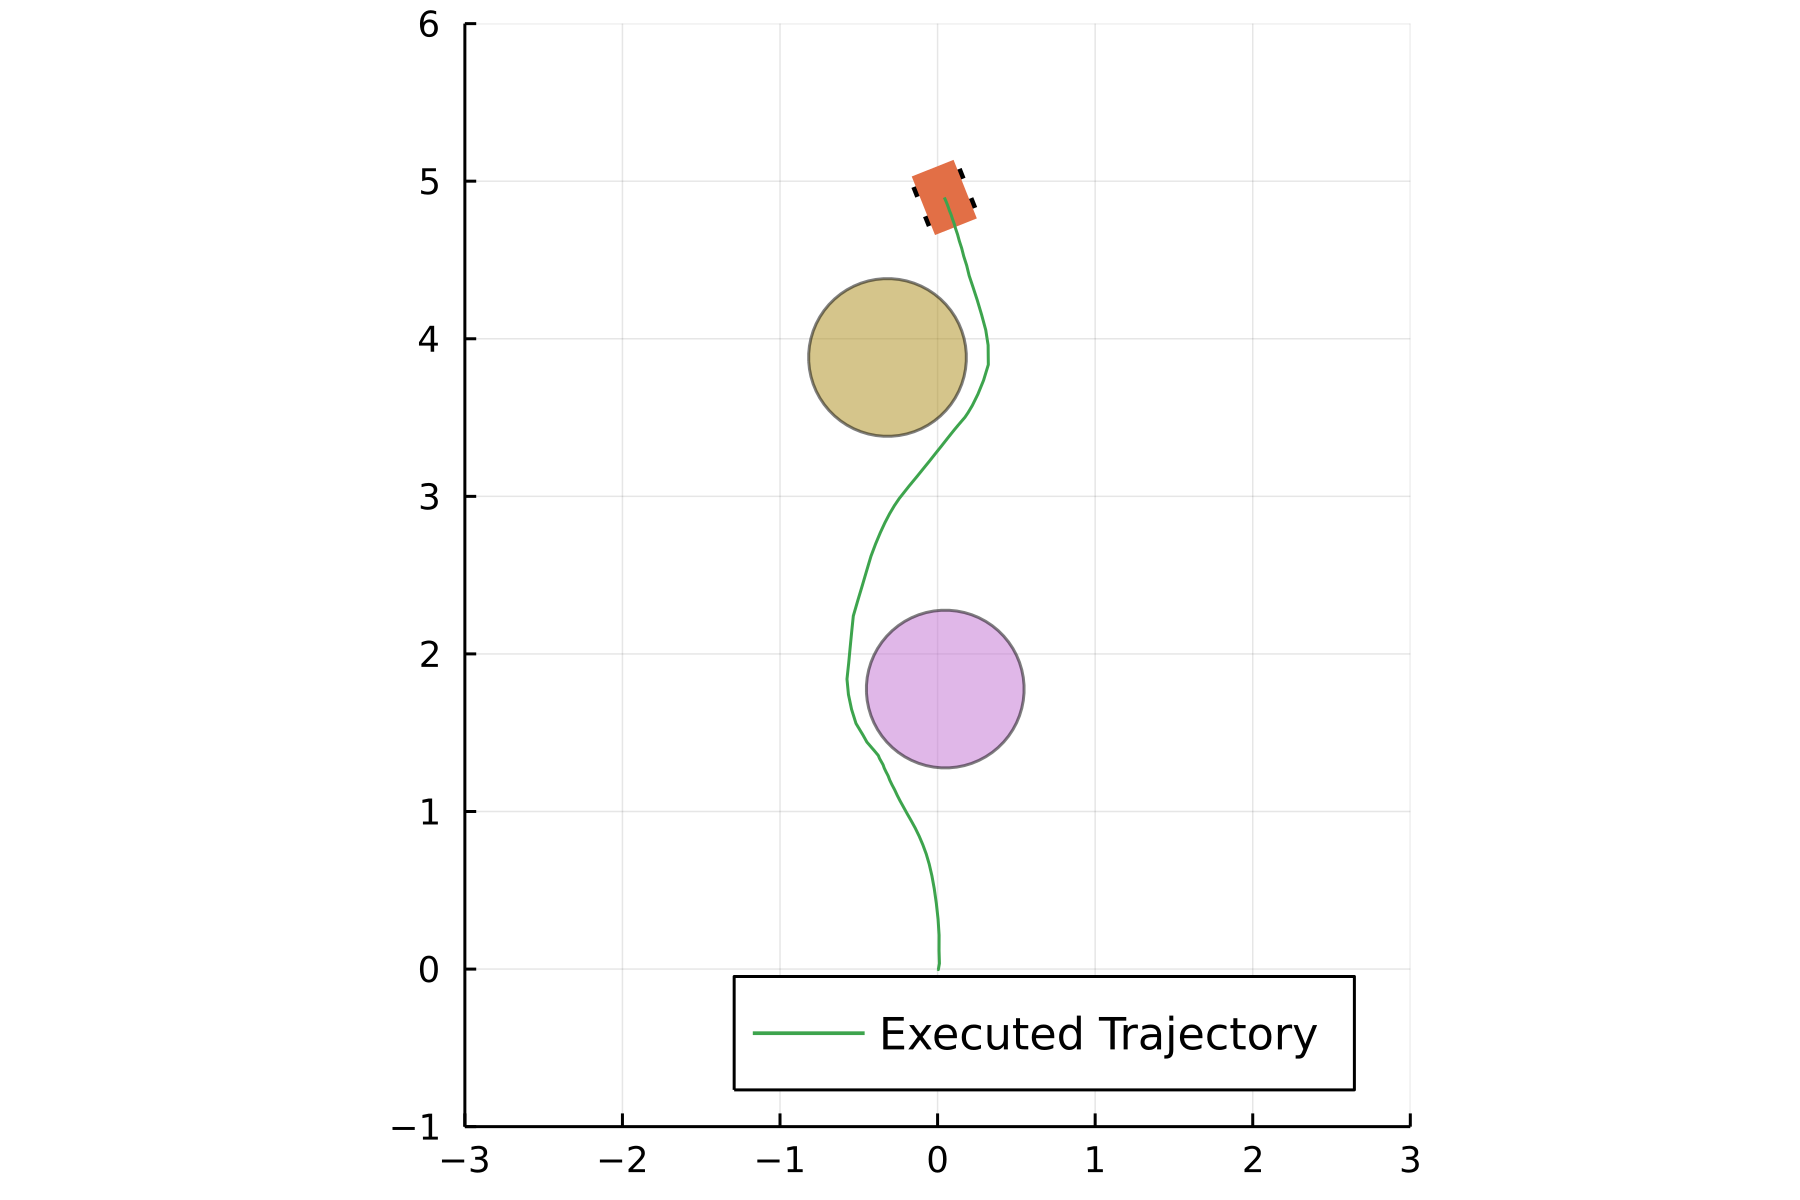

true

In [152]:
# visualize(Xshoot, obstacles=obstacles, xlims=[-3,3], ylims=[-1,6], fps=100)
visualize(Xexec2, obstacles=obstacles2, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec2)-1, "../results/collision_2.png"))

In [148]:
Random.seed!(7)
n = 3
obstacles3 = [Obstacle([rand()*1.2-0.6, rand()*3+1], [0,0], obs_radius) for i in 1:n]
x0=[0,0,0,π/2]
xg=[0,5,0,π/2]
obj_cost = [1,1,1,0.1]
rp = RP(net, obj_cost, x0, xg)

err_bound = [1, 1, 0.1, 0.1]*10
ctrl = NvController(err_bound, warm_start=true, bin_precision=1e-1)
ci = CollisionIndex(0.1, 1e-3, 2, 1)

Xexec3, Uexec, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=50, obstacles=obstacles3, safety_index=ci, verbose=false);

In [150]:
include("unicycle_env.jl")

generate_random_traj (generic function with 1 method)

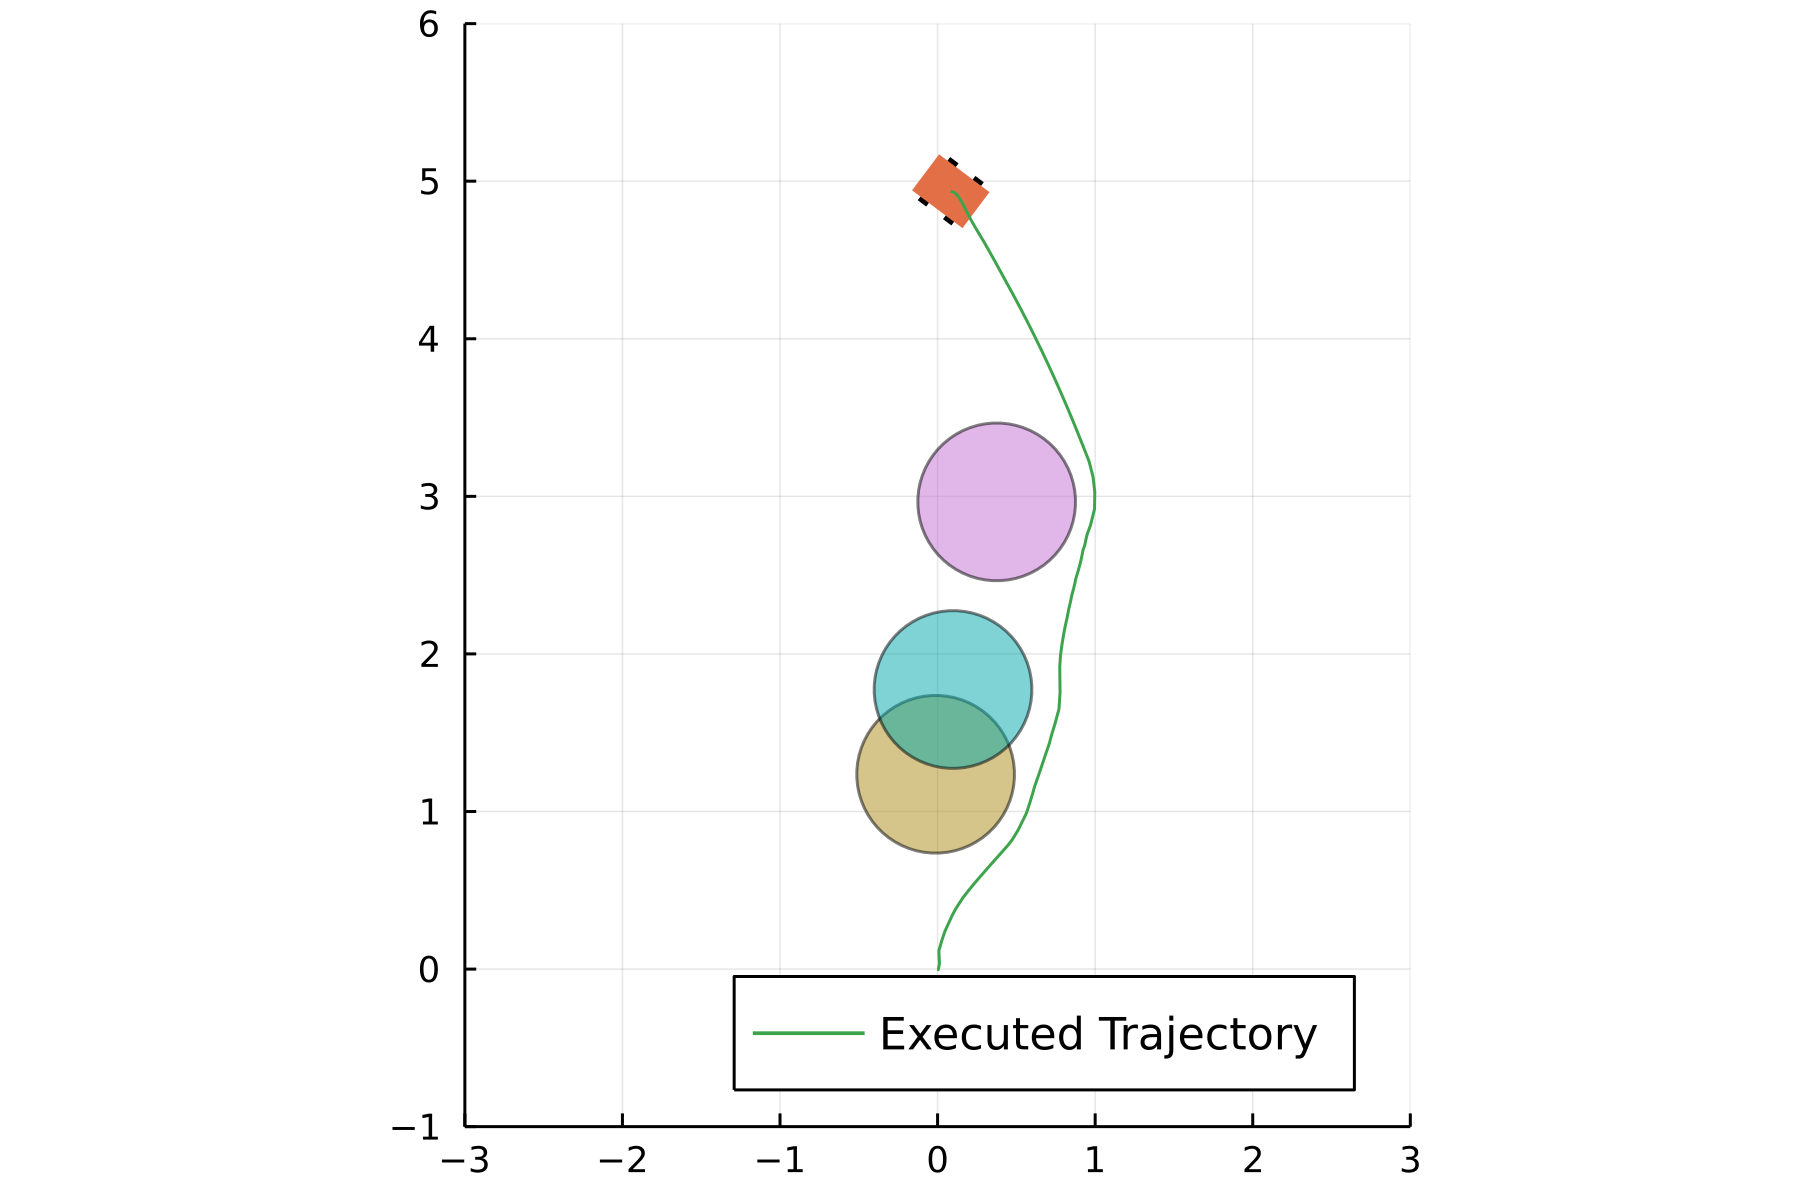

true

In [151]:
visualize(Xexec3, obstacles=obstacles3, xlims=[-3,3], ylims=[-1,6], fps=100, save_frame=(length(Xexec3)-1, "../results/collision_3.png"))

In [121]:
function collision_stat(num, ci; ctrl=nothing)
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    x0=[0,0,1,π/2]
    xg=[0,5,0,π/2]
    obj_cost = [1,1,1,0.1]
    rp = RP(net, obj_cost, x0, xg)
    n = 2
    for j in 1:num
        obstacles = [Obstacle([rand()*1-0.5, rand()*4+0.5], [0,0], obs_radius) for i in 1:n]
        ctrl = isnothing(ctrl) ? ShootingController(100) : ctrl
        Xtrack, Utrack, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=10, obstacles=obstacles, safety_index=ci, verbose=false);
        infeas_cnt += infeas
        vio=false
        for obs in obstacles
            for x in Xtrack
                if norm(x[1:2]-obs.center) < obs.radius
                    vio=true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
#         success += norm(xg[1:2] - Xtrack[end][1:2]) < 0.1
        success += 1-(vio|infeas)
    end
#     return success*1.0/num, phi0_vio_cnt, infeas_cnt*1.0/num
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

function following_stat(num, fi)
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    fps = 10
    tf = 2
    x0=[0,0,0,π/2]
    xg=[0,5,0,π/2]
    obj_cost = [1,1,0.1,0.1]
    rp = RP(net, obj_cost, x0, xg)
    for j in 1:num
        targets = generate_moving_target(fps=fps, tf=tf, v_lim=0.2)
#         obs = Obstacle([rand()*1-0.5, rand()*1+1], [0,0], obs_radius)
#         targets = [obs for i in 1:Int(tf*fps)]
        
        ctrl = ShootingController(100)
        Xtrack, Utrack, safe_sets, Xrefs, infeas = following(rp, ctrl, fps=fps, tf=tf, targets=targets, safety_index=fi, verbose=false);
        vio = false
        infeas_cnt += infeas
        for obs in targets
            for x in Xtrack
                if norm(x[1:2]-obs.center) < fi.d_min || norm(x[1:2]-obs.center) > fi.d_max
                    vio = true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
        success += 1 - (vio|infeas)
#         if j < 10
#             visualize(Xtrack, targets=targets, xlims=[-3,3], ylims=[-1,5], fps=1000)
#         end
    end
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

following_stat (generic function with 1 method)

In [107]:
ctrl = ShootingController(1000)
ci = CollisionIndex(0.1, 1e-3, 1, 0)
collision_stat(100, ci; ctrl=ctrl)

(0.0, 0.98, 1.0)

In [108]:
ci = CollisionIndex(0.1, 1e-3, 2, 1)
collision_stat(100, ci; ctrl=ctrl)

(0.75, 0.17, 0.08)

In [109]:
ci = CollisionIndex(0.1, 1e-3, 0.19546, 0.358787)
collision_stat(100, ci; ctrl=ctrl)

(0.82, 0.17, 0.02)

In [102]:
ctrl = ShootingController(100)

ShootingController([4.0, 3.141592653589793], 100)

In [103]:
ci = CollisionIndex(0.1, 1e-3, 1, 0)
collision_stat(100, ci; ctrl=ctrl)

(0.0, 0.99, 1.0)

In [104]:
ci = CollisionIndex(0.1, 1e-3, 2, 1)
collision_stat(100, ci; ctrl=ctrl)

(0.83, 0.07, 0.11)

In [105]:
ci = CollisionIndex(0.1, 1e-3, 0.19546, 0.358787)
collision_stat(100, ci; ctrl=ctrl)

(0.8, 0.2, 0.01)

In [42]:
ci = FollowingIndex(1, 2, 0.0, 1e-3, 1, 1e-9)
following_stat(100, ci)

(0.0, 78, 0.74)

In [43]:
ci = FollowingIndex(1, 2, 0.1, 1e-3, 1, 1)
following_stat(100, ci)

(0.23, 77, 0.0)

In [45]:
ci = FollowingIndex(1, 2, 0.4, 0.1, 1, 1)
following_stat(100, ci)

(0.97, 3, 0.0)

In [22]:
ci = FollowingIndex(1, 2, 0.2, 0.1, 1, 1)
following_stat(100, ci)

(0.95, 5, 0.0)

In [30]:
ci = FollowingIndex(1, 2, 0.2, 0.1, 1, 1e-9)
following_stat(100, ci)

(0.0, 16, 0.93)

In [27]:
ci = FollowingIndex(1, 2, 0.2, 0.1, 1, 1)
following_stat(100, ci)

(0.75, 25, 0.0)

In [28]:
ci = FollowingIndex(1, 2, 0.2, 0.1, 1, 1.5)
following_stat(100, ci)

(0.89, 11, 0.0)

ShootingController([4.0, 3.141592653589793], 1000)

(0.0, 0.0, 1.0)

(0.79, 0.14, 0.07)

(0.84, 0.15, 0.01)

In [61]:
ci = CollisionIndex(0.1, 1e-3, 0.730501, 1.41146)
collision_stat(100, ci)

(0.85, 0.15, 0.0)

In [48]:
function collision_samples()
    nx = 20
    ny = 20
    nv = 10
    nt = 10
    xs = range(0,stop=5,length=nx)
    ys = range(0,stop=5,length=ny)
    vs = range(-2,stop=2,length=nv)
    θs = range(-π,stop=π,length=nt)
    samples = [([x,y,v,θ],[Obstacle([0.0, 0.0],[0,0],obs_radius)]) for x in xs, y in ys, v in vs, θ in θs];
    return samples
end
col_samples = collision_samples();

function following_samples()
    nx = 10
    ny = 10
    nv = 10
    nt = 10
    nov = 2
    xs = range(0,stop=5,length=nx)
    ys = range(0,stop=5,length=ny)
    vs = range(-2,stop=2,length=nv)
    θs = range(-π,stop=π,length=nt)
    ov1s = range(-0.5,stop=0.5,length=nov)
    ov2s = range(-0.5,stop=0.5,length=nov)
    samples = [([x,y,v,θ],[Obstacle([0.0, 0.0],[ov1,ov2],obs_radius)]) for x in xs, y in ys, v in vs, θ in θs, ov1 in ov1s, ov2 in ov2s];
    return samples
end
fol_samples = following_samples();

In [128]:
function exists_valid_control(safety_index, ctrl::ShootingController, x, obs, net, dt)
    safe_set = phi_safe_set(safety_index, x, obs, dt)
    for j in 1:ctrl.num_sample
        u_cand = rand(2) .* ctrl.u_lim * 2 - ctrl.u_lim
        dot_x_cand = compute_output(net, [x; u_cand])
        dot_x_cand ∈ safe_set && (return true)
    end
    return false
end

function eval_collision_index(coes)
    phi_power, dot_phi_coe = coes
    margin = 0.1
    gamma = 1e-3
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in col_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    success_rate, phi0_vio_rate, infeas_rate = collision_stat(100, index)
    infeas_cnt = length(fol_samples)-valid
    @show coes, infeas_cnt, success_rate, phi0_vio_rate, infeas_rate
    return Float64(length(col_samples)-valid) - success_rate
end

function eval_following_index(coes)
    Random.seed!(1)
    margin, gamma, phi_power, dot_phi_coe = coes
#     gamma = 0.1
    d_min = 1
    d_max = 2
    index = FollowingIndex(d_min, d_max, margin, gamma, phi_power, dot_phi_coe)
    
    gamma = 1e-3
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in fol_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    success_rate, phi0_vio_rate, infeas_rate  = following_stat(100, index)
    infeas_cnt = length(fol_samples)-valid
    @show coes, infeas_cnt, success_rate, phi0_vio_rate, infeas_rate
    return Float64(length(fol_samples)-valid) - success_rate
end

eval_following_index (generic function with 1 method)

In [ ]:
# Evolutionary.optimize(eval_collision_index, [1.0, 0.0], CMAES())
for i = 1:10
    println("=========",i)
    Random.seed!(i)
    bboptimize(eval_collision_index; SearchRange = [(1e-3, 1e-2), (0.5, 3.0), (0.1, 3.0)], TraceMode=:verbose, MaxFuncEvals=20);
end

In [111]:
Random.seed!(127)
bboptimize(eval_following_index; SearchRange = [(0.1,0.5), (1e-2, 1.), (1.,1.), (0.0, 3.0)], TraceMode=:verbose, MaxFuncEvals=20);

LoadError: [91mInterruptException:[39m

In [112]:
Random.seed!(127)
bboptimize(eval_following_index; SearchRange = [(0.1,0.5), (1e-2, 1.), (2.,2.), (0.0, 3.0)], TraceMode=:verbose, MaxFuncEvals=20);

LoadError: [91mInterruptException:[39m

In [54]:
# Evolutionary.optimize(eval_collision_index, [1.0, 0.0], CMAES())
for i in 1:10
    println("=========",i)
    Random.seed!(i)
    bboptimize(eval_following_index; SearchRange = [(0.1,0.5), (1e-2, 1.), (1.,1.), (0.0, 3.0)], TraceMode=:verbose, MaxFuncEvals=20);
end

=========1


LoadError: [91mInterruptException:[39m

In [237]:
# Evolutionary.optimize(eval_collision_index, [1.0, 0.0], CMAES())
Random.seed!(127)
bboptimize(eval_collision_index; SearchRange = [(0.0, 3.0), (0.0, 3.0)], TraceMode=:verbose, MaxFuncEvals=20);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
56.04 secs, 2 evals, 1 steps, fitness=516.040000000
DE modify state:
110.91 secs, 4 evals, 2 steps, fitness=510.010000000
DE modify state:
161.22 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 1.0000), fitness=510.010000000
DE modify state:
204.70 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=510.010000000
DE modify state:
288.46 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 1.0000), fitness=-0.520000000
DE modify state:
337.14 secs, 12 evals, 6 steps, improv/step: 0.333 (last = 0.0000), fitness=-0.920000000
DE modify state:
387.24 secs, 14 evals, 7 steps, improv/step: 0.286 (last = 0.0000), fitness=-0.920000000
DE modify state:
430.21 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 1.0000), fitness=-0.920000000
DE modify state:
463.29 

In [239]:
ci = CollisionIndex(0.1, 0.19546, 0.358787)
collision_stat(100, ci)

(0.92, 0, 0.01)

In [358]:
for i = 2:10
    println("=========",i)
    Random.seed!(i)
    bboptimize(eval_collision_index; SearchRange = [(0.0, 3.0), (0.0, 3.0)], TraceMode=:verbose, MaxFuncEvals=15);
end

=========2
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
51.01 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=478.020000000
DE modify state:
96.52 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=418.150000000
DE modify state:
163.10 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=418.150000000
DE modify state:
227.26 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=418.150000000
DE modify state:
289.04 secs, 10 evals, 5 steps, improv/step: 1.000 (last = 1.0000), fitness=418.150000000
DE modify state:
355.79 secs, 12 evals, 6 steps, improv/step: 0.833 (last = 0.0000), fitness=-0.730000000
DE modify state:
399.16 secs, 14 evals, 7 steps, improv/step: 0.714 (last = 0.0000), fitness=-0.730000000
DE modify state:

Optimization stopped after 8 

459.86 secs, 9 evals, 5 steps, improv/step: 0.800 (last = 1.0000), fitness=-0.580000000
DE modify state:
501.82 secs, 11 evals, 6 steps, improv/step: 0.667 (last = 0.0000), fitness=-0.580000000
DE modify state:
569.13 secs, 13 evals, 7 steps, improv/step: 0.714 (last = 1.0000), fitness=-0.580000000
DE modify state:
602.72 secs, 15 evals, 8 steps, improv/step: 0.750 (last = 1.0000), fitness=-0.580000000
DE modify state:

Optimization stopped after 9 steps and 698.44 seconds
Termination reason: Max number of function evaluations (15) reached
Steps per second = 0.01
Function evals per second = 0.02
Improvements/step = Inf
Total function evaluations = 17


Best candidate found: [0.471815, 2.29597]

Fitness: -0.580000000

=========9
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
46.88 secs, 2 evals, 1 steps, improv/step: 1

In [178]:
@show eval_following_index([0.730501, 2.41146])

LoadError: [91mDomainError with -0.7:[39m
[91mExponentiation yielding a complex result requires a complex argument.[39m
[91mReplace x^y with (x+0im)^y, Complex(x)^y, or similar.[39m

In [ ]:
bboptimize(eval_following_index; SearchRange = [(0.0, 4.0), (0.0, 10.0)], TraceMode=:verbose, MaxFuncEvals=50);